In [ ]:
using SparseArrays, LinearAlgebra
#using Pkg
#Pkg.activate("../")
using Causality
using Plots

# Generation of Epidemics

In [ ]:
T, N = 20.0, 300
#G = Causality.makeBarabasi(N,k=2)
#ρ = 3/N
#G = Causality.makeGNP(N,ρ)
G = Causality.makeProximity(N,2.05/N)
G.A 

In [3]:
getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]


getpargen (generic function with 1 method)

In [17]:
#Initialize generation parameters
λ = 0.077
pseed = 1/N
ε = 1e-3
autoinf = GaussianRate(ε, T/2, 3T);
inf_in = GaussianRate(1.0, T/2, 3T)
inf_out = GaussianRate(λ, T/2, 3T)

θp = getpar(pseed, autoinf, inf_in);
θpgen = getpargen(pseed, autoinf, inf_out);

In [18]:
#Initialize min/max boundaies
T = Float64(T)
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

θmin = getpar(pseed_min , rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max);

rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max);

In [19]:
const Igen = GenerativeSI{GaussianRate,GaussianRate} 
const Igauss = GaussianInferentialSI

GaussianInferentialSI

In [24]:
Mp = StochasticModel(Igen, T, θp, G, θpgen);
sample! = Sampler(Mp);

xtrue = zeros(N)
sample!(xtrue)
nobs, p = 500, 1e-5
#nobs, p = N, 1e-5
O = [(i = rand(1:N); ti = T*rand(); (i,xtrue[i] < ti,ti,p)) for r=1:nobs]
sum(xtrue .< T)/N

0.36

## Causality (with inference of Infection Hyperparameter)

In [34]:
lattice_size = 10
F_lattice = zeros(lattice_size,lattice_size);

In [35]:
#Softened model
T = Float64(T)
inf_in = GaussianRate(1., T/2, 3*T );
ε = 1e-3
autoinf = GaussianRate(ε, T/2, T);


pseed_min = 1/N #1/(10*N)
pseed_max = 0.25
inf_min = 0.01
inf_max = 0.2
pseed, inf_out = pseed_min, GaussianRate(inf_min, T/2, 3*T)

step_inf = (inf_max - inf_min) / (lattice_size)
step_seed = (pseed_max - pseed_min) / (lattice_size)

for iinf in 1:lattice_size
    pseed = pseed_min
    for iseed in 1:1#lattice_size
        θp2gen = getpargen(pseed, autoinf, inf_out);
        θp2 = getpar(pseed, autoinf, inf_in);
        Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);
        θ = getpar(pseed, autoinf, inf_in);
        M = StochasticModel(Igauss, T, θ, G, θp2gen);
        descend!(Mp2, O; M=M, numsamples=1000, numiters=100, 
             θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
             hyperdescender=SignDescender(0.),hyper_mask=[2,3,4,6,7]);
        F_lattice[iinf,iseed] = descend!(Mp2, O; M=M, numsamples=1000, numiters=100, 
             θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
             hyperdescender=SignDescender(0.),hyper_mask=[2,3,4,6,7]);
       # pseed += step_seed
    end
    inf_out = GaussianRate(inf_min + iinf*step_inf, T/2, 3*T)
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/students/mmariani/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress: 100%|█████████████████████████████████████████| Time: 0:01:12
  F:  535.0387782347244


In [ ]:
using DelimitedFiles
open("../Hyperparams/provah.txt","w") do io
       writedlm(io,F_lattice') 
end

In [51]:
#now we do the descent
path = zeros(2,100)
pseed, inf_out = 1/N , GaussianRate(0.1, T/2, 3*T) #initial point
θp2gen = getpargen(pseed, autoinf, inf_out);
θp2 = getpar(pseed, autoinf, inf_in);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);
θ = getpar(pseed, autoinf, inf_in);
M = StochasticModel(Igauss, T, θ, G, θp2gen);
for st = 1:50
     descend!(Mp2, O; M=M, numsamples=4000, numiters=1, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.01),hyper_mask=[2,3,4,6,7]);
     path[1,st] = M.θgen[1]
     path[2,st] = M.θgen[5]
end
for st = 51:100
     descend!(Mp2, O; M=M, numsamples=4000, numiters=1, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
         hyperdescender=SignDescender(0.01),hyper_mask=[2,3,4,6,7]);
     path[1,st] = M.θgen[1]
     path[2,st] = M.θgen[5]
end
open("../Hyperparams/descent55.txt","w") do io
    writedlm(io,path') 
end

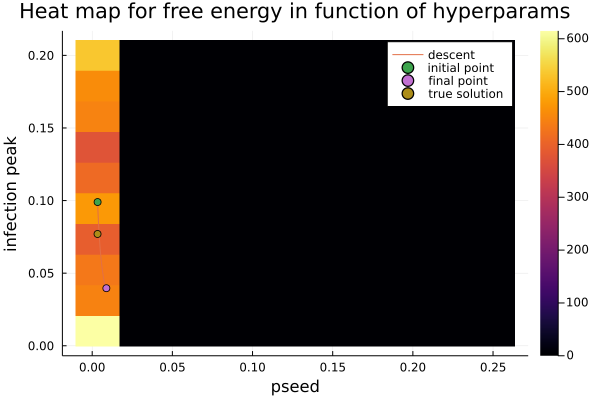

In [52]:
using Plots
heatmap(LinRange(pseed_min,pseed_max,lattice_size),LinRange(inf_min,inf_max,lattice_size),(F_lattice), xlabel="pseed", ylabel="infection peak",title="Heat map for free energy in function of hyperparams")
plot!(path[1,1:end],path[2,1:end],label="descent")
scatter!(path[1,1:1],path[2,1:1],label="initial point")
scatter!(path[1,end:end],path[2,end:end],label="final point")
scatter!([Mp.θgen[1],],[Mp.θgen[5],],label="true solution")
#savefig("descentVSmap")

In [43]:
path

2×200 Matrix{Float64}:
 0.00366667  0.00403333  0.00443667  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.09        0.081       0.0729         0.0  0.0  0.0  0.0  0.0  0.0  0.0

# A study on parameters variation

In [ ]:
pseed = 1/N
ε = 1e-3

final_st = 5
lam = LinRange(0.04,0.2,5)
infer_lam = zeros(length(lam))
n_infected = zeros(length(lam))
for st = 1:final_st
    for lam_num = 1:length(lam)
        λ = lam[lam_num] 
        autoinf = GaussianRate(ε, T/2, 3T);
        inf_in = GaussianRate(1.0, T/2, 3T)
        inf_out = GaussianRate(λ, T/2, 3T)

        θp = getpar(pseed, autoinf, inf_in);
        θpgen = getpargen(pseed, autoinf, inf_out);


        Mp = StochasticModel(Igen, T, θp, G, θpgen);
        sample! = Sampler(Mp);
        nobs, p = 1000, 1e-5
        ni = 0
        while ni<0.06 || ni>0.999
            sample!(xtrue)
            ni = sum(xtrue .< T) / N
        end
        n_infected[lam_num] += ni/final_st 
        O = [(i = rand(1:N); ti = T*rand(); (i,xtrue[i] < ti,ti,p)) for r=1:nobs]
        θp2gen = getpargen(pseed, autoinf, inf_out);
        θp2 = getpar(pseed, autoinf, inf_in);
        Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);
        θ = getpar(pseed, autoinf, inf_in);
        M = StochasticModel(Igauss, T, θ, G, θp2gen);
        descend!(Mp2, O; M=M, numsamples=5000, numiters=100, 
             θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
             hyperdescender=SignDescender(0.1),hyper_mask=[2,3,4,6,7]);
        descend!(Mp2, O; M=M, numsamples=5000, numiters=100, 
             θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
             hyperdescender=SignDescender(0.02),hyper_mask=[2,3,4,6,7]);
        infer_lam[lam_num] += M.θgen[5] / final_st
    end
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/students/mmariani/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress:  45%|██████████████████▌                      |  ETA: 0:03:18
  F:  812.316435054877

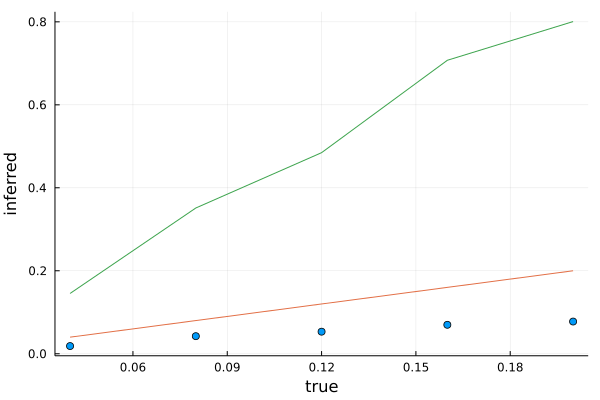

In [15]:
using Plots
scatter(lam,infer_lam,xlabel="true",ylabel="inferred",legend=false)
plot!(lam,lam)
plot!(lam,n_infected)

In [16]:
infer_lam

5-element Vector{Float64}:
 0.018535967768092236
 0.042362904786509115
 0.05318688873784079
 0.06976887947728029
 0.07761139709227613

In [ ]:
using DelimitedFiles
open("../Hyperparams/2lam0.04_0.2.txt","w") do io
    writedlm(io,infer_lam) 
end

open("../Hyperparams/2lam0.04_0.2infected.txt","w") do io
    writedlm(io,n_infected) 
end

## Comparison of free energy landascapes Causality vs "Exact" 
We want to see if the free energy landscape provided by causality is trustable or not. We need an exact profile to compare with. However, no exact method exists for epidemic problems. Therefore, we use the softmargin method which is close to the exact solution if few observations are made on the system. So we generate an instance with few observations and we compare the free energy profile of causality and softmargin

In [ ]:
using Plots
#We discard some observations in order to make softmargin almost exact.
Osoft = O[1:15]
totsamples = 2 * 10^5

lattice_size = 20
Fcau_lattice = zeros(lattice_size,lattice_size);
Fsoft_lattice = zeros(lattice_size,lattice_size);
FSsoft_lattice = zeros(lattice_size,lattice_size);

T = Float64(T)
inf_in = GaussianRate(1., T/2, 3*T );
ε = 1e-3
autoinf = GaussianRate(ε, T/2, T);


pseed_min = 1/(10*N)
pseed_max = 0.25
inf_min = 0.01
inf_max = 0.7
pseed, inf_out = pseed_min, GaussianRate(inf_min, T/2, 3*T)

step_inf = (inf_max - inf_min) / (lattice_size)
step_seed = (pseed_max - pseed_min) / (lattice_size)

for iinf in 1:lattice_size
    pseed = pseed_min
    for iseed in 1:lattice_size
        θp2gen = getpargen(pseed, autoinf, inf_out);
        θp2 = getpar(pseed, autoinf, inf_in);
        Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);
        θ = getpar(pseed, autoinf, inf_in);
        M = StochasticModel(Igauss, T, θ, G, θp2gen);
        descend!(Mp2, Osoft; M=M, numsamples=1000, numiters=100, 
             θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
             hyperdescender=SignDescender(0.),hyper_mask=[2,3,4,6,7]);
        Fcau_lattice[iinf,iseed] = descend!(Mp2, Osoft; M=M, numsamples=1000, numiters=100, 
             θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
             hyperdescender=SignDescender(0.),hyper_mask=[2,3,4,6,7]);
        stats, weight = softpostnoise(Mp2, Osoft; numsamples=totsamples);
        Fsoft_lattice[iinf,iseed] = - log(sum(weight)/totsamples)
        Sstats,Sweight = softpostnoise(Mp2, Osoft; numsamples=10*totsamples);
        FSsoft_lattice[iinf,iseed] = - log(sum(Sweight)/(10*totsamples))
        pseed += step_seed
    end
    inf_out = GaussianRate(inf_min + iinf*step_inf, T/2, 3*T)
end


┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/students/mmariani/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
  F:  9.26287294427819
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress:  51%|████████████████████▉                    |  ETA: 0:00:58

In [ ]:
heatmap(LinRange(pseed_min,pseed_max,lattice_size),LinRange(inf_min,inf_max,lattice_size),log.(Fcau_lattice), xlabel="pseed", ylabel="infection peak")

In [ ]:
heatmap(LinRange(pseed_min,pseed_max,lattice_size),LinRange(inf_min,inf_max,lattice_size),log.(Fsoft_lattice), xlabel="pseed", ylabel="infection peak")

In [ ]:
heatmap(LinRange(pseed_min,pseed_max,lattice_size),LinRange(inf_min,inf_max,lattice_size),log.(FSsoft_lattice), xlabel="pseed", ylabel="infection peak")